In [24]:
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *
from scoring import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=5, preprocess=True)

# NOTE: Unlike past data collection, the sentences have been randomized
# among annotators, meaning analysis which averages across sentences or calculates
# inter-annotator agreement may be wrong. Need to fix dataloading to re-sort sentences
# with the same annotators together.

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json']

Found users: {'ayush', 'anton'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
Couldn't process grammar for deletion: ['perfect', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['perfect', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['perfect', 'no', '']. Assum

In [25]:
# Print spans with comments
get_comments(data)

ANTON - HIT 3: no change




In [26]:
# The systems we looked at
systems = set([x['system'] for x in data])

# Edit types
edit_types = set(data[0]['annotations'].keys())

In [27]:
# Example: Searches for coreference errors
deletions = [process_annotation(k) for k in [i for j in [[x for x in sent['edits'] if x['type'] == 'deletion'] for sent in data] for i in j]]
for d in deletions:
    if d['error_type'] == Error.COREFERENCE:
        print(d)

In [28]:
# Example: Some of the annotations for sentence 0
data[0]['processed_annotations'][:2]

[{'edit_type': 'deletion',
  'id': 0,
  'information_impact': <Information.LESS: 'Less Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 3,
  'size': 0.008310249307479225,
  'score': 0.970747553725849},
 {'edit_type': 'deletion',
  'id': 1,
  'information_impact': <Information.LESS: 'Less Information'>,
  'type': <Quality.QUALITY: 'No Error'>,
  'grammar_error': False,
  'error_type': None,
  'rating': 2,
  'size': 0.030470914127423823,
  'score': 0.8085959365626684}]

In [29]:
# Example: Some of the edits for sentence 0
data[0]['edits'][:2]

[{'type': 'deletion',
  'id': 0,
  'original_span': [(92, 95)],
  'simplified_span': None,
  'annotation': ['perfect', 'no', 'no']},
 {'type': 'deletion',
  'id': 1,
  'original_span': [(113, 124)],
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']}]

In [30]:
# Example: Agreement between annotators on edit types
# for edit_type in ['deletion', 'insertion', 'reorder', 'substitution']:
#     print(f'{edit_type} -> {calculate_agreement(data, edit_type, drop_no_spans=True)}')

In [ ]:
# TODO: trivial edits on substitutions aren't being processed correctly
# for sent in data:
#     for ann in sent['processed_annotations']:
#         if ann['type'] == Quality.TRIVIAL and ann['rating'] == None:
#             print(sent['id'])
#             print([e for e in sent['edits'] if e['type'] == 'substitution'])
#             print(ann)
#             print(sent['system'])
#             print(sent['system'])
#             print(sent['user'])

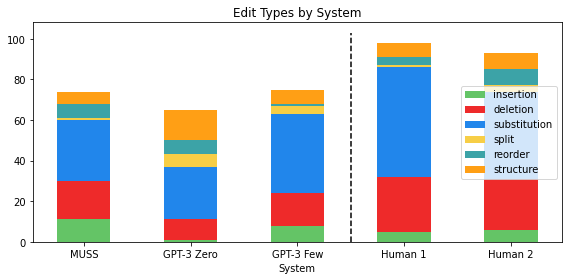

In [ ]:
edit_type_by_system(data, flipped=True)

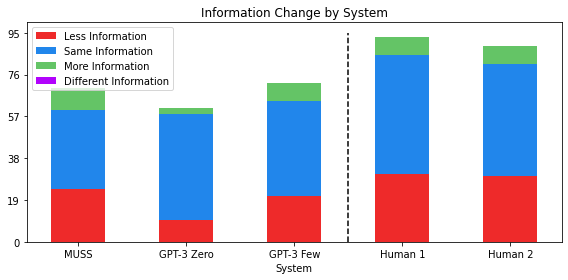

In [ ]:
system_by_information_change(data)

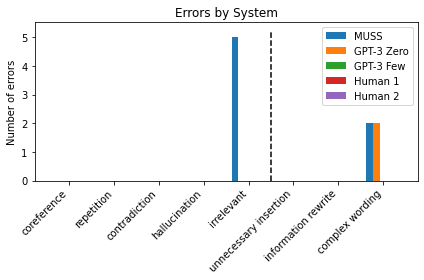

In [ ]:
errors_by_system(data)

In [ ]:
sankey_seperated(data)

In [ ]:
sankey_combined(data)

In [ ]:
# Prints the sentences where annotators identified insertion errors
for error in [Error.REPETITION, Error.CONTRADICTION, Error.HALLUCINATION, Error.IRRELEVANT]:
    print(f'\n{error.value}')
    for sent in data:
        for ann in sent['processed_annotations']:
            if ann['error_type'] == error:
                print(f'{get_sent_info(sent)} \t {system_name_mapping[sent["system"]]}')


Repetition

Contradiction

Hallucination

Irrelevant
anton - Batch 5, HIT 5 (ID 4) 	 MUSS
anton - Batch 5, HIT 13 (ID 12) 	 MUSS
anton - Batch 5, HIT 25 (ID 24) 	 MUSS
ayush - Batch 5, HIT 24 (ID 24) 	 MUSS
anton - Batch 5, HIT 29 (ID 28) 	 MUSS


In [ ]:
# Print the avg. sentence scores for each system
for s in systems:
    print(f'{system_name_mapping[s]} \t {avg([sent["score"] for sent in data if sent["system"] == s])}')

MUSS 	 -4.45
GPT-3 Zero 	 6.51
Human 2 	 12.1
Human 1 	 6.39
GPT-3 Few 	 8.58


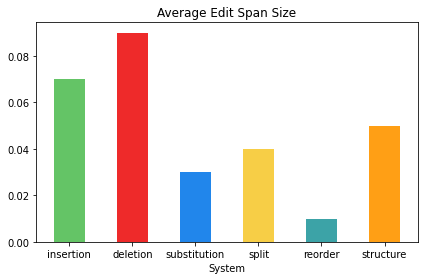

In [ ]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

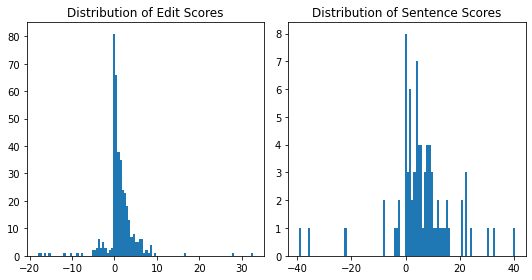

In [ ]:
# Show the distribution of edit and sentence scores
score_distribution(data)

In [ ]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
anton - Batch 5, HIT 40 (ID 39) - 40.218971182996725
anton - Batch 5, HIT 12 (ID 11) - 32.83140529936834
anton - Batch 5, HIT 11 (ID 10) - 30.346412493102576
anton - Batch 5, HIT 2 (ID 1) - 23.840686721928265
anton - Batch 5, HIT 37 (ID 36) - 22.6448570516668

Lowest scoring:
anton - Batch 5, HIT 25 (ID 24) - -39.259024054328535
anton - Batch 5, HIT 29 (ID 28) - -35.68429768544705
anton - Batch 5, HIT 5 (ID 4) - -21.890553349768176
ayush - Batch 5, HIT 24 (ID 24) - -7.964951982698696
ayush - Batch 5, HIT 36 (ID 55) - -7.742587096549681


In [ ]:
# Get setences with a score of 0
zeros = zero_scoring_sents(data)

anton - Batch 5, HIT 19 (ID 18)
ayush - Batch 5, HIT 14 (ID 18)


In [ ]:
# edit_length(data, systems, simpeval=True)

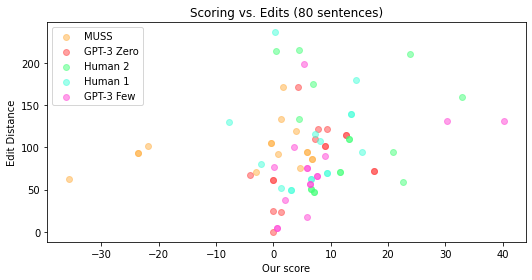

In [ ]:
# Averages our scores before plotting
import copy
new_data = copy.deepcopy(data)

for id_ in set([sent['id'] for sent in data]):
    sents = [sent for sent in data if sent['id'] == id_]
    new_score = avg([sent['score'] for sent in sents])
    for i in range(len(new_data)):
        if new_data[i]['id'] == id_:
            new_data[i]['score'] = new_score
            
edit_length(new_data, systems, simpeval=False)

In [ ]:
# Get sentences with at least 1 structure change from 1 annotator
ids = set()
for sent in data:
    if 'structure' in [x['type'] for x in sent['edits']]:
        ids.add(sent['id'])
ids = sorted(list(ids))
print(f'Sentences with at least 1 structure change: {len(ids)} / {len(data)}')

Sentences with at least 1 structure change: 32 / 80


anton - Batch 5, HIT 2 (ID 1)

The architecture of Winchester College is a diverse set of architectural styles, reflecting the multiple periods of building from the college's foundation in 1382, through additions in the medieval and Early Modern periods, to a major expansion of accommodation in the Victorian era and then further extensions at the turn of the 20th century and more recently.
Winchester College’s architecture includes a variety of architectural styles. || This reflects multiple periods of building from when the college was founded in 1382 way until its most recent extensions. || This includes additions made during the medieval and Early Modern periods and a major expansion of accommodation in the Victorian era.



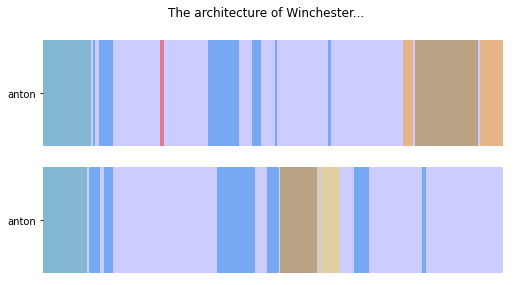

In [ ]:
# Display a sentence with a structure change
id_ = 1
sents = [sent for sent in data if sent['id'] == ids[id_]]
print_changes(sents)
draw_agreement(sents)